In [99]:
import serial
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import math

In [104]:
pwm_ser = serial.Serial()
attempts = 0
pwm_ser_open = False

while not pwm_ser_open and attempts < 50:
    if not pwm_ser_open:
        try:
            pwm_ser = serial.Serial('com22', 115200, timeout=0.1)
            pwm_ser_open = True
        except:
            print("Failed to open pwm serial port: ", attempts)
            attempts += 1
            
pwm_ser.flush()

start = time.time()

cmd_df = pd.DataFrame(columns=['Time', 'Steer', 'Speed'])
zrc_df = pd.DataFrame(columns=['Time', 'Status', 'Command', 'Steer', 'Speed'])

step_cntr = 0
last_step_time = time.time()
last_cmd_time = time.time()

while time.time() - start < 10.0:
    pwm_ser.flushInput()
    pwm_bytes = pwm_ser.readline()
    # print("pwm_bytes: ", pwm_bytes)
    try:
        decoded_pwm_strings = str(pwm_bytes[0:len(pwm_bytes)-2].decode("utf-8")).split(',')
        # print("decoded pwm string: ", decoded_pwm_strings)
        if decoded_pwm_strings[0] == 'Z':
            # This is a measured PWM report
            z_status = int(decoded_pwm_strings[1])
            z_time = int(decoded_pwm_strings[2])
            z_command = int(decoded_pwm_strings[3])
            z_steer = int(decoded_pwm_strings[4])
            z_speed = int(decoded_pwm_strings[5])
            z_checksum = int(decoded_pwm_strings[6])
            checksum = (z_command + z_steer + z_speed) % 1000
            if z_checksum == checksum:
                rc_log = [z_time, z_status, z_command, z_steer, z_speed]
                zrc_df.loc[len(zrc_df)] = rc_log
                
        elif decoded_pwm_strings[0] == 'C':
            # This is a measured PWM report
            z_time = int(decoded_pwm_strings[1])
            z_steer = int(decoded_pwm_strings[2])
            z_speed = int(decoded_pwm_strings[3])
            z_checksum = int(decoded_pwm_strings[4])
            checksum = (z_steer + z_speed) % 1000
            if z_checksum == checksum:
                cmd_log = [z_time, z_steer, z_speed]
                cmd_df.loc[len(cmd_df)] = cmd_log
                
        elif decoded_pwm_strings[0] == 'E':
            print("Error message recieved - Arduino has timed out waiting for a command")
    except:
        print("Error decoding and splitting pwm bytes")
    
    try:
        if time.time() - last_step_time > 0.5:
            last_step_time = time.time()
            step_cntr = step_cntr + 1
            
        if time.time() - last_cmd_time > 0.01:
            last_cmd_time = time.time()
            cmd = step_cntr * 1 + 1580
            cmd_str = ('C,' + str(cmd) + ',' + str(cmd) + ',' + str((2 * cmd) % 1000) + '\r\n').encode("utf-8")
            # print("cmd_str: ", cmd_str)
            pwm_ser.write(cmd_str)
    except:
        print("Error writing to Arduino")
        
pwm_ser.close()




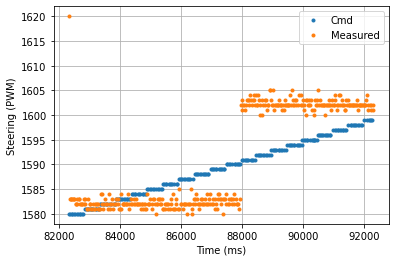

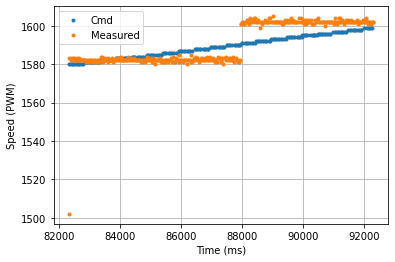

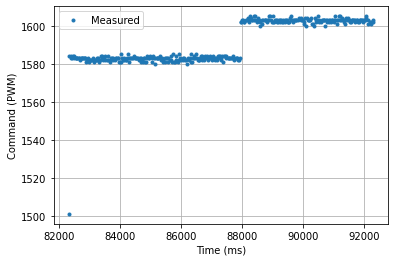

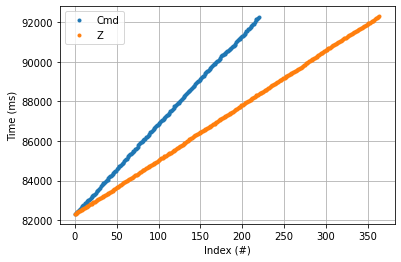

In [105]:
plt.plot(cmd_df['Time'], cmd_df['Steer'], '.', label='Cmd')
plt.plot(zrc_df['Time'], zrc_df['Steer'], '.', label='Measured')
plt.grid()
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Steering (PWM)')
plt.show()

plt.plot(cmd_df['Time'], cmd_df['Speed'], '.', label='Cmd')
plt.plot(zrc_df['Time'], zrc_df['Speed'], '.', label='Measured')
plt.grid()
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Speed (PWM)')
plt.show()

plt.plot(zrc_df['Time'], zrc_df['Command'], '.', label='Measured')
plt.grid()
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Command (PWM)')
plt.show()

plt.plot(cmd_df['Time'], '.', label='Cmd')
plt.plot(zrc_df['Time'], '.', label='Z')
plt.grid()
plt.ylabel('Time (ms)')
plt.xlabel('Index (#)')
plt.legend()
plt.show()